In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas import DataFrame
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import dask.dataframe as dd
import shap

/home/rob/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Below we have called in the pathogenic noncoding region dataframe:

In [2]:
pathogenic_noncoding_region = pd.read_csv("pathogenic_noncoding_region_variants.csv")
pathogenic_noncoding_region.head()

/home/rob/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0 #Chrom      Pos Ref Alt Type  Length           AnnoType  \
0           0      1  7961859   C   G  SNV       0  RegulatoryFeature   
1           1      1  7961859   C   G  SNV       0         Transcript   
2           2      1  9720021   G   A  SNV       0  RegulatoryFeature   
3           3      1  9720021   G   A  SNV       0         Transcript   
4           4      1  9975590   A   G  SNV       0         Transcript   

        Consequence  ConsScore  ... BP4  BP5  BP6  BP7 cosmic70  MCAP  REVEL  \
0        REGULATORY          4  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
1          INTRONIC          2  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
2        REGULATORY          4  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
3       SPLICE_SITE          5  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
4  CANONICAL_SPLICE          6  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   

  regsnp_fpr regsnp_disease regsnp_splicing_site  
0        NaN            NaN                  NaN  
1        NaN            NaN                  NaN  
2        NaN            NaN                  NaN  
3        NaN            NaN                  NaN  
4        NaN            NaN                  NaN  

[5 rows x 242 columns]

Below we have cut out columns we will not use for our model, since they do not improve the model's learning ability:

In [3]:
pathogenic_noncoding_region = pathogenic_noncoding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

Below we show how many rows are in the above dataframe:

In [4]:
len(pathogenic_noncoding_region)

11258

For our model, we cannot have NaN values since the model cannot interpret what this means. Therefore, we must change the NaN values to 0. This process is shown below:

In [ ]:
pd.options.display.max_rows = 400
pathogenic_noncoding_region.isnull().sum()

In [ ]:
pathogenic_noncoding_region = pathogenic_noncoding_region.fillna(0)
pd.options.display.max_rows = 400
pathogenic_noncoding_region.isnull().sum()

Below we show some statistics for all the columns that contain numerical values in our dataframe:

In [7]:
pd.options.display.max_rows = 10
pathogenic_noncoding_region.describe()

ConsScore            GC           CpG   motifECount   motifEHIPos  \
count  11258.000000  11258.000000  11258.000000  11258.000000  11258.000000   
mean       3.974773      0.514107      0.061995      0.152070      0.011370   
std        2.369051      0.124159      0.067711      0.948325      0.106026   
min        1.000000      0.212000      0.000000      0.000000      0.000000   
25%        2.000000      0.417000      0.013000      0.000000      0.000000   
50%        4.000000      0.510000      0.040000      0.000000      0.000000   
75%        6.000000      0.609000      0.080000      0.000000      0.000000   
max        8.000000      0.833000      0.347000     18.000000      1.000000   

       motifEScoreChng        cDNApos    relcDNApos         CDSpos  \
count     11258.000000   11258.000000  11258.000000   11258.000000   
mean         -0.000435    3699.566264      0.105585    3631.375555   
std           0.009914   16366.543273      0.233694   16329.422830   
min          -0.165000       0.000000      0.000000       0.000000   
25%           0.000000       0.000000      0.000000       0.000000   
50%           0.000000       0.000000      0.000000       0.000000   
75%           0.000000       0.000000      0.000000       0.000000   
max           0.094000  108117.000000      0.993000  107892.000000   

          relCDSpos  ...           BP1      BP2      BP3           BP4  \
count  11258.000000  ...  11258.000000  11258.0  11258.0  11258.000000   
mean       0.110160  ...      0.036063      0.0      0.0      0.014479   
std        0.254088  ...      0.186456      0.0      0.0      0.119458   
min        0.000000  ...      0.000000      0.0      0.0      0.000000   
25%        0.000000  ...      0.000000      0.0      0.0      0.000000   
50%        0.000000  ...      0.000000      0.0      0.0      0.000000   
75%        0.000000  ...      0.000000      0.0      0.0      0.000000   
max        0.999000  ...      1.000000      0.0      0.0      1.000000   

           BP5           BP6           BP7          MCAP         REVEL  \
count  11258.0  11258.000000  11258.000000  11258.000000  11258.000000   
mean       0.0      0.005330      0.002398      0.080532      0.146098   
std        0.0      0.072812      0.048916      0.215199      0.299715   
min        0.0      0.000000      0.000000      0.000000      0.000000   
25%        0.0      0.000000      0.000000      0.000000      0.000000   
50%        0.0      0.000000      0.000000      0.000000      0.000000   
75%        0.0      0.000000      0.000000      0.000000      0.000000   
max        0.0      1.000000      1.000000      0.997434      0.996000   

         regsnp_fpr  
count  11258.000000  
mean       0.008941  
std        0.037464  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.003587  
max        0.715753  

[8 rows x 174 columns]

To distinguish the pathogenic variants from the benign variants, we add a column called 'category' to each. The pathogenic variants will be assigned the value '1' while the benign variants will be assigend the value '0'

In [8]:
pathogenic_noncoding_region['category']=1

In [9]:
pathogenic_noncoding_region.head()

Ref Alt       Consequence  ConsScore       ConsDetail     GC    CpG  \
0   C   G        REGULATORY          4       regulatory  0.781  0.253   
1   C   G          INTRONIC          2           intron  0.781  0.253   
2   G   A        REGULATORY          4       regulatory  0.603  0.067   
3   G   A       SPLICE_SITE          5    splice,intron  0.603  0.067   
4   A   G  CANONICAL_SPLICE          6  splice_acceptor  0.371  0.013   

   motifECount motifEName  motifEHIPos  ...  BP5  BP6  BP7 cosmic70 MCAP  \
0          0.0          0          0.0  ...  0.0  0.0  0.0        0  0.0   
1          0.0          0          0.0  ...  0.0  0.0  0.0        0  0.0   
2          0.0          0          0.0  ...  0.0  0.0  0.0        0  0.0   
3          0.0          0          0.0  ...  0.0  0.0  0.0        0  0.0   
4          0.0          0          0.0  ...  0.0  0.0  0.0        0  0.0   

  REVEL regsnp_fpr regsnp_disease regsnp_splicing_site  category  
0   0.0        0.0              0                    0         1  
1   0.0        0.0              0                    0         1  
2   0.0        0.0              0                    0         1  
3   0.0        0.0              0                    0         1  
4   0.0        0.0              0                    0         1  

[5 rows x 236 columns]

#### Benign Noncoding:

Below we have called in the benign noncoding region dataframe:

In [10]:
benign_noncoding_region = dd.read_csv("benign_noncoding_final_dataframe_with_nan_and_floats.csv", dtype={'AAChange.ensGene': 'object',
       'AAChange.knownGene': 'object',
       'AAChange.refGene': 'object',
       'Domain': 'object',
       'Eigen_coding_or_noncoding': 'object',
       'Exon': 'object',
       'ExonicFunc.ensGene': 'object',
       'ExonicFunc.knownGene': 'object',
       'ExonicFunc.refGene': 'object',
       'FATHMM_pred': 'object',
       'FATHMM_pred.1': 'object',
       'InterVar_automated': 'object',
       'Interpro_domain': 'object',
       'Interpro_domain.1': 'object',
       'LRT_pred': 'object',
       'LRT_pred.1': 'object',
       'LR_pred': 'object',
       'M-CAP_pred': 'object',
       'MetaLR_pred': 'object',
       'MetaSVM_pred': 'object',
       'MutationAssessor_pred': 'object',
       'MutationAssessor_pred.1': 'object',
       'MutationTaster_pred': 'object',
       'MutationTaster_pred.1': 'object',
       'PROVEAN_pred': 'object',
       'PolyPhenCat': 'object',
       'Polyphen2_HDIV_pred': 'object',
       'Polyphen2_HDIV_pred.1': 'object',
       'Polyphen2_HVAR_pred': 'object',
       'Polyphen2_HVAR_pred.1': 'object',
       'RadialSVM_pred': 'object',
       'SIFT_pred': 'object',
       'SIFT_pred.1': 'object',
       'SIFTcat': 'object',
       'cosmic70': 'object',
       'fathmm-MKL_coding_pred': 'object',
       'nAA': 'object',
       'oAA': 'object',
        'GTEx_V6_gene': 'object',
       'GTEx_V6_tissue': 'object',
        '#Chrom': 'object'}).compute()
benign_noncoding_region.head()

/home/rob/anaconda3/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/home/rob/anaconda3/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (93,94,95,217,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/home/rob/anaconda3/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/home/rob/anaconda3/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (93,94,95,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/home/rob/anaconda3/lib/python3.6/site-packages/dask/core.py:118: DtypeWarning: Columns (93,233,2

Unnamed: 0  Unnamed: 0.1 #Chrom AAChange.ensGene AAChange.knownGene  \
0           0             0      1              NaN                NaN   
1           1             1      1              NaN                NaN   
2           2             2      1              NaN                NaN   
3           3             3      1              NaN                NaN   
4           4             4      1              NaN                NaN   

  AAChange.refGene Alt           AnnoType  BA1  BP1  ...  regsnp_disease  \
0              NaN   A  RegulatoryFeature  NaN  NaN  ...             NaN   
1              NaN   A         Transcript  NaN  NaN  ...             NaN   
2              NaN   G  RegulatoryFeature  NaN  NaN  ...             NaN   
3              NaN   G         Transcript  NaN  NaN  ...             NaN   
4              NaN   A  RegulatoryFeature  NaN  NaN  ...             NaN   

   regsnp_fpr  regsnp_splicing_site  relCDSpos  relProtPos  relcDNApos  \
0         NaN                   NaN        NaN         NaN         NaN   
1         NaN                   NaN        NaN         NaN         NaN   
2         NaN                   NaN        NaN         NaN         NaN   
3         NaN                   NaN        NaN         NaN         NaN   
4         NaN                   NaN        NaN         NaN         NaN   

   tOverlapMotifs  targetScan  verPhCons  verPhyloP  
0             NaN         NaN        0.0     -0.799  
1             NaN         NaN        0.0     -0.799  
2             NaN         NaN        0.0      0.156  
3             NaN         NaN        0.0      0.156  
4             NaN         NaN        0.0      0.076  

[5 rows x 243 columns]

Again we cut out the columns not helpful to our model:

In [11]:
benign_noncoding_region = benign_noncoding_region.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

Below we show how many rows are in the above dataframe:

In [12]:
len(benign_noncoding_region)

1538949

Next we will show how many values are in each column of our dataframe:

In [13]:
benign_noncoding_region.count()

AAChange.ensGene         6054
AAChange.knownGene       6876
AAChange.refGene         5639
Alt                   1538949
BA1                      4897
                       ...   
relcDNApos              15328
tOverlapMotifs         141641
targetScan                527
verPhCons             1532536
verPhyloP             1532536
Length: 235, dtype: int64

Below we have changed all the NaN values to 0 so that our model will work with the values:

In [14]:
benign_noncoding_region = benign_noncoding_region.fillna(0)

Next we show some statistics about the different annotations in the dataframe:

In [15]:
benign_noncoding_region.describe()

BA1           BP1        BP2        BP3           BP4  \
count  1.538949e+06  1.538949e+06  1538949.0  1538949.0  1.538949e+06   
mean   1.221613e-04  2.540695e-04        0.0        0.0  2.385394e-03   
std    1.105199e-02  1.593754e-02        0.0        0.0  4.878223e-02   
min    0.000000e+00  0.000000e+00        0.0        0.0  0.000000e+00   
25%    0.000000e+00  0.000000e+00        0.0        0.0  0.000000e+00   
50%    0.000000e+00  0.000000e+00        0.0        0.0  0.000000e+00   
75%    0.000000e+00  0.000000e+00        0.0        0.0  0.000000e+00   
max    1.000000e+00  1.000000e+00        0.0        0.0  1.000000e+00   

             BP5           BP6           BP7           BS1        BS2  ...  \
count  1538949.0  1.538949e+06  1.538949e+06  1.538949e+06  1538949.0  ...   
mean         0.0  3.879271e-04  1.645279e-03  4.152184e-04        0.0  ...   
std          0.0  1.969205e-02  4.052867e-02  2.037269e-02        0.0  ...   
min          0.0  0.000000e+00  0.000000e+00  0.000000e+00        0.0  ...   
25%          0.0  0.000000e+00  0.000000e+00  0.000000e+00        0.0  ...   
50%          0.0  0.000000e+00  0.000000e+00  0.000000e+00        0.0  ...   
75%          0.0  0.000000e+00  0.000000e+00  0.000000e+00        0.0  ...   
max          0.0  1.000000e+00  1.000000e+00  1.000000e+00        0.0  ...   

          priPhyloP       protPos    regsnp_fpr     relCDSpos    relProtPos  \
count  1.538949e+06  1.538949e+06  1.538949e+06  1.538949e+06  1.538949e+06   
mean  -2.135189e-01  3.637534e+00  3.634313e-02  5.789977e-04  5.805806e-04   
std    8.239168e-01  2.781245e+02  1.516422e-01  1.945383e-02  1.950075e-02   
min   -8.560000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%   -5.760000e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.730000e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.040000e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    5.950000e-01  3.587400e+04  1.000000e+00  1.000000e+00  1.002000e+00   

         relcDNApos  tOverlapMotifs    targetScan     verPhCons     verPhyloP  
count  1.538949e+06    1.538949e+06  1.538949e+06  1.538949e+06  1.538949e+06  
mean   4.983473e-03    1.342202e-01  2.958123e-02  3.878888e-02 -2.752123e-01  
std    5.791269e-02    5.658361e-01  1.613878e+00  1.553558e-01  1.017225e+00  
min    0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00 -1.547700e+01  
25%    0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00 -7.300000e-01  
50%    0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00 -1.140000e-01  
75%    0.000000e+00    0.000000e+00  0.000000e+00  4.000000e-03  2.540000e-01  
max    1.000000e+00    4.000000e+01  9.900000e+01  1.000000e+00  1.122500e+01  

[8 rows x 172 columns]

Just as we had to create a new column and set the pathogenic variants variants to 1, we must do the same for the benign variants setting them equal to 0:

In [16]:
#set categories to 0 for human Drive 
benign_noncoding_region['category']=0

In [17]:
benign_noncoding_region.head()

AAChange.ensGene AAChange.knownGene AAChange.refGene Alt  BA1  BP1  BP2  \
0                0                  0                0   A  0.0  0.0  0.0   
1                0                  0                0   A  0.0  0.0  0.0   
2                0                  0                0   G  0.0  0.0  0.0   
3                0                  0                0   G  0.0  0.0  0.0   
4                0                  0                0   A  0.0  0.0  0.0   

   BP3  BP4  BP5  ...  regsnp_fpr  regsnp_splicing_site  relCDSpos  \
0  0.0  0.0  0.0  ...         0.0                     0        0.0   
1  0.0  0.0  0.0  ...         0.0                     0        0.0   
2  0.0  0.0  0.0  ...         0.0                     0        0.0   
3  0.0  0.0  0.0  ...         0.0                     0        0.0   
4  0.0  0.0  0.0  ...         0.0                     0        0.0   

   relProtPos  relcDNApos  tOverlapMotifs  targetScan  verPhCons  verPhyloP  \
0         0.0         0.0             0.0         0.0        0.0     -0.799   
1         0.0         0.0             0.0         0.0        0.0     -0.799   
2         0.0         0.0             0.0         0.0        0.0      0.156   
3         0.0         0.0             0.0         0.0        0.0      0.156   
4         0.0         0.0             0.0         0.0        0.0      0.076   

   category  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 236 columns]

Since there are only 11,258 pathogenic noncoding variants as opposed to 1,538,949 benign noncoding variants, we must take a random sample of the noncoding variants so that the numbers of the two sets are close, as to not bias our machine learning model towards one or the other. 

We should take a **1%** sample of the benign noncoding variants for our model. This will give us a much more balanced number of variants for the pathogenic and benign variants, shown below:

In [18]:
benign_noncoding_region_sample = benign_noncoding_region.sample(frac=0.010, random_state = 1)

In [19]:
benign_noncoding_region_sample.head()

AAChange.ensGene AAChange.knownGene AAChange.refGene Alt  BA1  BP1  BP2  \
33100                0                  0                0   T  0.0  0.0  0.0   
84611                0                  0                0   G  0.0  0.0  0.0   
79291                0                  0                0   G  0.0  0.0  0.0   
21115                0                  0                0   C  0.0  0.0  0.0   
2833                 0                  0                0   A  0.0  0.0  0.0   

       BP3  BP4  BP5  ...  regsnp_fpr  regsnp_splicing_site  relCDSpos  \
33100  0.0  0.0  0.0  ...         0.0                     0        0.0   
84611  0.0  0.0  0.0  ...         0.0                     0        0.0   
79291  0.0  0.0  0.0  ...         0.0                     0        0.0   
21115  0.0  0.0  0.0  ...         0.0                     0        0.0   
2833   0.0  0.0  0.0  ...         0.0                     0        0.0   

       relProtPos  relcDNApos  tOverlapMotifs  targetScan  verPhCons  \
33100         0.0         0.0             0.0         0.0      0.209   
84611         0.0         0.0             1.0         0.0      0.000   
79291         0.0         0.0             0.0         0.0      0.000   
21115         0.0         0.0             1.0         0.0      0.000   
2833          0.0         0.0             0.0         0.0      0.020   

       verPhyloP  category  
33100      0.193         0  
84611     -3.933         0  
79291     -1.456         0  
21115      0.047         0  
2833       0.233         0  

[5 rows x 236 columns]

Below we show how many rows our sample has:

In [20]:
len(benign_noncoding_region_sample)

15389

Below we show that there are no NaN values in our sample:

In [21]:
pd.options.display.max_rows = 4000
benign_noncoding_region_sample.isnull().sum()

AAChange.ensGene                        0
AAChange.knownGene                      0
AAChange.refGene                        0
Alt                                     0
BA1                                     0
BP1                                     0
BP2                                     0
BP3                                     0
BP4                                     0
BP5                                     0
BP6                                     0
BP7                                     0
BS1                                     0
BS2                                     0
BS3                                     0
BS4                                     0
CADD_phred                              0
CADD_phred.1                            0
CADD_raw                                0
CADD_raw.1                              0
CADD_raw_rankscore                      0
CCDS                                    0
CDSpos                                  0
ConsDetail                        

Below we show a few statistics for the annotations (notice the dataframe below has 173 columns since we added the category column above as well):

In [22]:
benign_noncoding_region_sample.describe()

BA1           BP1      BP2      BP3           BP4      BP5  \
count  15389.000000  15389.000000  15389.0  15389.0  15389.000000  15389.0   
mean       0.000065      0.000650      0.0      0.0      0.002664      0.0   
std        0.008061      0.025484      0.0      0.0      0.051549      0.0   
min        0.000000      0.000000      0.0      0.0      0.000000      0.0   
25%        0.000000      0.000000      0.0      0.0      0.000000      0.0   
50%        0.000000      0.000000      0.0      0.0      0.000000      0.0   
75%        0.000000      0.000000      0.0      0.0      0.000000      0.0   
max        1.000000      1.000000      0.0      0.0      1.000000      0.0   

                BP6          BP7           BS1      BS2  ...       protPos  \
count  15389.000000  15389.00000  15389.000000  15389.0  ...  15389.000000   
mean       0.000455      0.00169      0.000390      0.0  ...     11.820261   
std        0.021324      0.04107      0.019742      0.0  ...    561.141545   
min        0.000000      0.00000      0.000000      0.0  ...      0.000000   
25%        0.000000      0.00000      0.000000      0.0  ...      0.000000   
50%        0.000000      0.00000      0.000000      0.0  ...      0.000000   
75%        0.000000      0.00000      0.000000      0.0  ...      0.000000   
max        1.000000      1.00000      1.000000      0.0  ...  30717.000000   

         regsnp_fpr     relCDSpos    relProtPos    relcDNApos  tOverlapMotifs  \
count  15389.000000  15389.000000  15389.000000  15389.000000    15389.000000   
mean       0.034213      0.000757      0.000759      0.005515        0.129508   
std        0.146728      0.022395      0.022433      0.060482        0.530515   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000      0.000000        0.000000   
50%        0.000000      0.000000      0.000000      0.000000        0.000000   
75%        0.000000      0.000000      0.000000      0.000000        0.000000   
max        1.000000      0.966000      0.968000      0.984000       20.000000   

         targetScan     verPhCons     verPhyloP  category  
count  15389.000000  15389.000000  15389.000000   15389.0  
mean       0.024693      0.039646     -0.272263       0.0  
std        1.531461      0.158601      1.021752       0.0  
min        0.000000      0.000000     -8.819000       0.0  
25%        0.000000      0.000000     -0.738000       0.0  
50%        0.000000      0.000000     -0.119000       0.0  
75%        0.000000      0.004000      0.253000       0.0  
max       95.000000      1.000000      8.896000       0.0  

[8 rows x 173 columns]

Below we combine the pathogenic and benign variants:

In [22]:
features = pd.concat([pathogenic_noncoding_region,benign_noncoding_region_sample],axis=0, join='outer',ignore_index=True)
pd.options.display.max_rows = 8
pd.options.display.max_columns = 8
features = features.fillna(0)

/home/rob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Below is the length of the combined dataframe:

In [23]:
len(features)

26647

Below we show the data types of the columns. This will show us which columns will be subjected to one hot encoding (object and string):

In [ ]:
pd.options.display.max_rows = 240
features.dtypes == object

Before one hot encoding the data, we want to know if we can take out any of the categorical annotation columns and any numerical columns which have no values. The reason for doing this is because if there is a categorical column in which nearly every value is different, the result of one hot encoding will be a final dataframe with thousands of columns. These columns will not improve the machine learning model since they will not lead to a grouping of pathogenic or benign. Below we find the number of unique values in each column:

In [ ]:
features.nunique()

Now we look at all the categorical values. It is a difficult decision to choose which annotations should make it. I have decided to drop columns with more than 1,000 unique values and over 20,000 values of 0. The reason for this is that quantitatively, dividing 6,000 maximum variants by 1,000 values gives many small groups, not providing any improvement to the machine learning model. We look at these columns below:

In [27]:
features['AAChange.ensGene'].value_counts()

0                                                                                                                                                                                               22656
TYMP:ENST00000252029.7:exon9:c.G1160A:p.G387D,TYMP:ENST00000395678.7:exon9:c.G1160A:p.G387D,TYMP:ENST00000395680.5:exon9:c.G1160A:p.G387D,TYMP:ENST00000395681.5:exon9:c.G1175A:p.G392D            16
TYMP:ENST00000252029.7:exon10:c.C1412A:p.S471X,TYMP:ENST00000395678.7:exon10:c.C1412A:p.S471X,TYMP:ENST00000395680.5:exon10:c.C1412A:p.S471X,TYMP:ENST00000395681.5:exon10:c.C1427A:p.S476X        16
TYMP:ENST00000252029.7:exon9:c.G1282A:p.G428S,TYMP:ENST00000395678.7:exon9:c.G1282A:p.G428S,TYMP:ENST00000395680.5:exon9:c.G1282A:p.G428S,TYMP:ENST00000395681.5:exon9:c.G1297A:p.G433S            16
TYMP:ENST00000395681.5:exon9:c.A1173G:p.A391A                                                                                                                                                      16
          

In [117]:
features['AAChange.knownGene'].value_counts()

0                                                                                                                                                                                                         22565
UNKNOWN                                                                                                                                                                                                      29
TYMP:uc062fmw.1:exon9:c.C1313A:p.S438X,TYMP:uc003bmc.7:exon10:c.C1412A:p.S471X,TYMP:uc003bmd.7:exon10:c.C1412A:p.S471X,TYMP:uc003bme.7:exon10:c.C1427A:p.S476X,TYMP:uc010hbd.6:exon10:c.C1412A:p.S471X       16
TYMP:uc003bme.7:exon9:c.G1174A:p.G392S                                                                                                                                                                       16
                                                                                                                                                                        

In [118]:
features['AAChange.refGene'].value_counts()

0                                                                                                                                                                                                                22680
TYMP:NM_001113756:exon8:c.G1282A:p.G428S,TYMP:NM_001113755:exon9:c.G1282A:p.G428S,TYMP:NM_001257988:exon9:c.G1282A:p.G428S,TYMP:NM_001257989:exon9:c.G1297A:p.G433S,TYMP:NM_001953:exon9:c.G1282A:p.G428S           16
TYMP:NM_001113756:exon9:c.G1360C:p.A454P,TYMP:NM_001113755:exon10:c.G1360C:p.A454P,TYMP:NM_001257988:exon10:c.G1360C:p.A454P,TYMP:NM_001257989:exon10:c.G1375C:p.A459P,TYMP:NM_001953:exon10:c.G1360C:p.A454P       16
TYMP:NM_001113756:exon8:c.G1160A:p.G387D,TYMP:NM_001113755:exon9:c.G1160A:p.G387D,TYMP:NM_001257988:exon9:c.G1160A:p.G387D,TYMP:NM_001257989:exon9:c.G1175A:p.G392D,TYMP:NM_001953:exon9:c.G1160A:p.G387D           16
                                                                                                                                            

In [127]:
features['GeneDetail.ensGene'].value_counts()

0                                                                                                              22404
ENST00000395680.5:exon9:c.1160-1G>A;ENST00000252029.7:exon9:c.1160-1G>A;ENST00000395678.7:exon9:c.1160-1G>A       16
ENST00000395680.5:exon9:c.1160-2A>G;ENST00000252029.7:exon9:c.1160-2A>G;ENST00000395678.7:exon9:c.1160-2A>G       16
ENST00000395680.5:exon9:c.1160-2A>C;ENST00000252029.7:exon9:c.1160-2A>C;ENST00000395678.7:exon9:c.1160-2A>C       16
                                                                                                               ...  
dist=21623;dist=2974                                                                                               1
dist=25002;dist=36944                                                                                              1
dist=52619;dist=66853                                                                                              1
dist=26690;dist=32018                                           

In [128]:
features['GeneDetail.knownGene'].value_counts()

0                                                                                                                                                                                               22579
uc010hbd.6:exon9:c.1160-2A>C;uc003bmc.7:exon9:c.1160-2A>C;uc003bmd.7:exon9:c.1160-2A>C;uc062fmw.1:exon8:c.1061-2A>C                                                                                16
uc010hbd.6:exon9:c.1160-1G>C;uc003bmc.7:exon9:c.1160-1G>C;uc003bmd.7:exon9:c.1160-1G>C;uc062fmw.1:exon8:c.1061-1G>C                                                                                16
uc021wsa.2:exon1:UTR5;uc062fmt.1:exon1:UTR5;uc010hbd.6:exon8:c.1159+2T>A;uc003bme.7:exon8:c.1159+2T>A;uc003bmc.7:exon8:c.1159+2T>A;uc003bmd.7:exon8:c.1159+2T>A;uc062fmw.1:exon7:c.1060+2T>A       16
                                                                                                                                                                                                ...  
uc060fdj.1

In [129]:
features['GeneDetail.refGene'].value_counts()

0                                                                                                                           21647
NM_001953:exon9:c.1160-2A>C;NM_001257988:exon9:c.1160-2A>C;NM_001113756:exon8:c.1160-2A>C;NM_001113755:exon9:c.1160-2A>C       16
NM_001281532:exon4:c.167-2A>G;NM_172341:exon4:c.167-2A>G                                                                       16
NM_001953:exon9:c.1160-2A>G;NM_001257988:exon9:c.1160-2A>G;NM_001113756:exon8:c.1160-2A>G;NM_001113755:exon9:c.1160-2A>G       16
                                                                                                                            ...  
NM_000488:exon3:c.624+1G>T                                                                                                      1
NM_001257180:exon8:c.935-1G>A;NM_006749:exon8:c.935-1G>A;NM_001257181:exon8:c.935-1G>A                                          1
dist=719162;dist=172034                                                                   

To help us with our model, we also want to take out any columns whose values are all or very nearly all 0. We see this result in the code below:

In [54]:
features.BA1.value_counts()

0.0    26646
1.0        1
Name: BA1, dtype: int64

In [55]:
features.BP1.value_counts()

0.0    26231
1.0      416
Name: BP1, dtype: int64

In [56]:
features.BP2.value_counts()

0.0    26647
Name: BP2, dtype: int64

In [58]:
features.BP3.value_counts()

0.0    26647
Name: BP3, dtype: int64

In [59]:
features.BP4.value_counts()

0.0    26443
1.0      204
Name: BP4, dtype: int64

In [60]:
features.BP5.value_counts()

0.0    26647
Name: BP5, dtype: int64

In [61]:
features.BP6.value_counts()

0.0    26580
1.0       67
Name: BP6, dtype: int64

In [62]:
features.BP7.value_counts()

0.0    26594
1.0       53
Name: BP7, dtype: int64

In [50]:
features.BS1.value_counts()

0.0    26598
1.0       49
Name: BS1, dtype: int64

In [51]:
features.BS2.value_counts()

0.0    26647
Name: BS2, dtype: int64

In [52]:
features.BS3.value_counts()

0.0    26647
Name: BS3, dtype: int64

In [67]:
features.BS4.value_counts()

0.0    26647
Name: BS4, dtype: int64

In [76]:
features.GTEx_V6_gene.value_counts()

0.0    26647
Name: GTEx_V6_gene, dtype: int64

In [77]:
features.GTEx_V6_tissue.value_counts()

0.0    26647
Name: GTEx_V6_tissue, dtype: int64

In [79]:
features.PM1.value_counts()

0.0    25191
1.0     1456
Name: PM1, dtype: int64

In [80]:
features.PM2.value_counts()

0.0    23508
1.0     3139
Name: PM2, dtype: int64

In [81]:
features.PM3.value_counts()

0.0    26647
Name: PM3, dtype: int64

In [82]:
features.PM4.value_counts()

0.0    26647
Name: PM4, dtype: int64

In [83]:
features.PM5.value_counts()

0.0    26597
1.0       50
Name: PM5, dtype: int64

In [84]:
features.PM6.value_counts()

0.0    26647
Name: PM6, dtype: int64

In [86]:
features.PP1.value_counts()

0.0    26647
Name: PP1, dtype: int64

In [87]:
features.PP2.value_counts()

0.0    26356
1.0      291
Name: PP2, dtype: int64

In [88]:
features.PP3.value_counts()

0.0    24291
1.0     2356
Name: PP3, dtype: int64

In [89]:
features.PP4.value_counts()

0.0    26647
Name: PP4, dtype: int64

In [90]:
features.PP5.value_counts()

0.0    25238
1.0     1409
Name: PP5, dtype: int64

In [92]:
features.PS1.value_counts()

0.0    26638
1.0        9
Name: PS1, dtype: int64

In [93]:
features.PS2.value_counts()

0.0    26647
Name: PS2, dtype: int64

In [94]:
features.PS3.value_counts()

0.0    26647
Name: PS3, dtype: int64

In [95]:
features.PS4.value_counts()

0.0    26647
Name: PS4, dtype: int64

In [97]:
features.PVS1.value_counts()

0.0    25762
1.0      885
Name: PVS1, dtype: int64

In [100]:
features.integrated_confidence_value.value_counts()

0.0    26453
1.0      145
2.0       47
3.0        2
Name: integrated_confidence_value, dtype: int64

In [101]:
features.targetScan.value_counts()

0.0     26628
53.0        4
95.0        4
86.0        4
94.0        3
69.0        3
88.0        1
Name: targetScan, dtype: int64

Below we drop all the columns not needed for the model. This will improve classification and run time:

In [24]:
features = features.drop(columns = ['targetScan', 'integrated_confidence_value', 'PVS1', 'PS4', 'PS3', 'PS2',
                        'PS1', 'PP5', 'PP4', 'PP3', 'PP2', 'PP1', 'PM6', 'PM5', 'PM4', 'PM3', 'PM2',
                        'PM1', 'GTEx_V6_tissue', 'GTEx_V6_gene', 'BS4', 'BS3', 'BS2', 'BS1', 
                        'BP7', 'BP6', 'BP5', 'BP4', 'BP3', 'BP2', 'BP1', 'BA1', 'GeneDetail.refGene',
                        'GeneDetail.knownGene', 'GeneDetail.ensGene', 'AAChange.refGene', 
                        'AAChange.knownGene', 'AAChange.ensGene'])
features
# Notice how we only have 198 columns now

Alt  CADD_phred  CADD_phred.1  CADD_raw  ...  relcDNApos  \
0       G         0.0           0.0       0.0  ...         0.0   
1       G         0.0           0.0       0.0  ...         0.0   
2       A         0.0           0.0       0.0  ...         0.0   
3       A         0.0           0.0       0.0  ...         0.0   
...    ..         ...           ...       ...  ...         ...   
26643   G         0.0           0.0       0.0  ...         0.0   
26644   C         0.0           0.0       0.0  ...         0.0   
26645   G         0.0           0.0       0.0  ...         0.0   
26646   T         0.0           0.0       0.0  ...         0.0   

       tOverlapMotifs verPhCons  verPhyloP  
0                 0.0     0.001     -0.334  
1                 0.0     0.001     -0.334  
2                 0.0     0.000     -1.643  
3                 0.0     0.000     -1.643  
...               ...       ...        ...  
26643             0.0     0.000     -0.100  
26644             0.0     0.004      0.176  
26645             0.0     0.046      0.238  
26646             0.0     0.000     -0.610  

[26647 rows x 198 columns]

Below we one hot encode our combined dataframe. This takes the categorical columns and creates a matrix for the values with 0s and 1s corresponding to each individual categorical value. This allows for classification by the model based solely on numerical values:

In [25]:
# Before dropping the columns above, there were 55,355 columns
# Notice that we need to specify the dtype as float in order for our model to work below
features = pd.get_dummies(features, dtype = float)
features

CADD_phred  CADD_phred.1  CADD_raw  CADD_raw.1  ...  regsnp_disease_PD  \
0             0.0           0.0       0.0         0.0  ...                0.0   
1             0.0           0.0       0.0         0.0  ...                0.0   
2             0.0           0.0       0.0         0.0  ...                0.0   
3             0.0           0.0       0.0         0.0  ...                0.0   
...           ...           ...       ...         ...  ...                ...   
26643         0.0           0.0       0.0         0.0  ...                0.0   
26644         0.0           0.0       0.0         0.0  ...                0.0   
26645         0.0           0.0       0.0         0.0  ...                0.0   
26646         0.0           0.0       0.0         0.0  ...                0.0   

       regsnp_splicing_site_0  regsnp_splicing_site_off  \
0                         1.0                       0.0   
1                         1.0                       0.0   
2                         1.0                       0.0   
3                         1.0                       0.0   
...                       ...                       ...   
26643                     1.0                       0.0   
26644                     1.0                       0.0   
26645                     1.0                       0.0   
26646                     1.0                       0.0   

       regsnp_splicing_site_on  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
...                        ...  
26643                      0.0  
26644                      0.0  
26645                      0.0  
26646                      0.0  

[26647 rows x 44046 columns]

Below we show the data types of all the columns:

In [26]:
pd.options.display.max_rows = 240
features.dtypes

CADD_phred                  float64
CADD_phred.1                float64
CADD_raw                    float64
CADD_raw.1                  float64
CADD_raw_rankscore          float64
                             ...   
regsnp_disease_D            float64
regsnp_disease_PD           float64
regsnp_splicing_site_0      float64
regsnp_splicing_site_off    float64
regsnp_splicing_site_on     float64
Length: 44046, dtype: object

Notice how there are much fewer columns in this dataframe than for the coding region. The reason for this must be that there were more values for annotations in the coding region. This is because one hot encoding creates a new columns for every specific value in a categorical column. Thus, there were many more unique values in the categorical columns in the coding region than in the noncoding region.

Below we create a variable for the category column which we will use later for our model:

In [27]:
labels = features['category']
labels

0        1
1        1
2        1
3        1
4        1
        ..
26642    0
26643    0
26644    0
26645    0
26646    0
Name: category, Length: 26647, dtype: int64

Below we made our category column into a numpy array to be used in the model:

In [28]:
labels = labels.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

Below we drop the category column because our machine learning model uses it only for the labels:

In [ ]:
features = features.drop('category', axis = 1)
features.head()

Below we create a list of the column names which we will use later to see the influence of each annotation:

In [234]:
feature_list = list(features.columns)

In [30]:
len(feature_list)

NameError: name 'feature_list' is not defined

Below we show the number of columns in the dataframe:

In [126]:
len(features.columns)

44045

Now that all our data is numeric, we want to transform it into a numpy array to use in our model:

In [243]:
features = features.to_numpy()

Now we will split our data into testing and training data to later use for our model. We do a 75% training data to 25% testing data split:

In [244]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 100)

Below we show the dataframe for the training set:

In [103]:
pd.options.display.max_rows = 8
pd.options.display.max_columns = 10
train_features

array([[ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [27.1  , 26.1  ,  4.798, ...,  0.   ,  0.   ,  1.   ]])

Below we show the dataframe for the testing set:

In [104]:
test_features

array([[ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       ...,
       [ 6.328, 10.45 ,  0.429, ...,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [23.1  , 28.5  ,  4.377, ...,  0.   ,  0.   ,  1.   ]])

Below we show the list of training labels from our category column:

In [105]:
train_labels

array([0, 0, 1, ..., 0, 0, 1])

Below we show the list of testing labels from our category column:

In [106]:
test_labels

array([0, 1, 0, ..., 1, 0, 1])

To see the dimensions of the arrays we are using for our model, we execute the following code:

In [107]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (19985, 44045)
Training Labels Shape: (19985,)
Testing Features Shape: (6662, 44045)
Testing Labels Shape: (6662,)


## Trial Run:

Below we create and test a very small sample of our data to see if the classifier works:

In [116]:
small_testing_sample_for_classifier = features.sample(frac=0.010, random_state = 1)

In [117]:
labels_sample = small_testing_sample_for_classifier['category']
labels_sample = labels_sample.to_numpy()
small_testing_sample_for_classifier = small_testing_sample_for_classifier.drop('category', axis = 1)
small_testing_sample_for_classifier = small_testing_sample_for_classifier.to_numpy()
train_features, test_features, train_labels, test_labels = train_test_split(small_testing_sample_for_classifier, labels_sample, test_size = 0.25, random_state = 100)
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf = 5, bootstrap = False)
model = rforest.fit(train_features, train_labels)

In [118]:
# Perform 6-fold cross validation
scores = cross_val_score(model, train_features, train_labels, cv=6, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.88235294 0.82352941 0.75757576 0.81818182 0.81818182 0.84375   ]


## End of Trial Run

Below we run our model with all data keeping in mind all the parameters for the RandomForestClassifier function:

In [255]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf = 5, bootstrap = False)
model = rforest.fit(train_features, train_labels)
#RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_split=1e-07, min_samples_leaf=5,
#            min_samples_split=5, min_weight_fraction_leaf=0.0,
#            n_estimators=500, n_jobs=2, oob_score=False, random_state=0,
#            verbose=0, warm_start=False)

Below we run cross validation on our model to see how well it performed on the training data:

In [146]:
# Perform 6-fold cross validation
scores = cross_val_score(model, train_features, train_labels, cv=6, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.98709096 0.98498949 0.98649054 0.98498949 0.98649054 0.98678679]


Below we run cross validation on our model to see how well it performs on the testing data:

In [257]:
# Perform 3-fold cross validation
scores = cross_val_score(model, test_features, test_labels, cv=3, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.96533093 0.96803242 0.97522523]


Now we create a precision-recall curve for the classifier following the guidelines of https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/:

f1=0.984 auc=0.997 ap=0.997


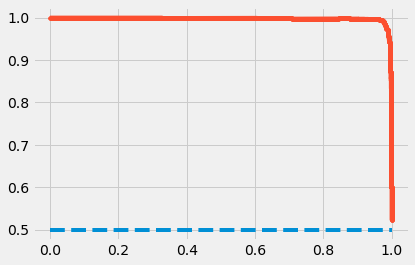

In [258]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
probs = model.predict_proba(test_features)
probs = probs[:,1]
labels_hat = model.predict(test_features)
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
f1 = f1_score(test_labels, labels_hat)
auc = auc(recall, precision)
ap = average_precision_score(test_labels, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
plt.plot([0,1], [0.5, 0.5], linestyle = '--')
plt.plot(recall, precision, marker = '.')
plt.show()

Below we show how much each annotation actually influenced the classification of the variants for this model:

In [259]:
# Get numerical feature importances
importances = list(rforest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PHRED                Importance: 0.04
Variable: MutationTaster_score Importance: 0.02
Variable: RawScore             Importance: 0.02
Variable: mamPhCons            Importance: 0.02
Variable: mamPhyloP            Importance: 0.02
Variable: verPhCons            Importance: 0.02
Variable: verPhyloP            Importance: 0.02
Variable: Func.refGene_0       Importance: 0.02
Variable: CADD_phred           Importance: 0.01
Variable: CADD_phred.1         Importance: 0.01
Variable: CADD_raw             Importance: 0.01
Variable: CADD_raw.1           Importance: 0.01
Variable: CADD_raw_rankscore   Importance: 0.01
Variable: ConsScore            Importance: 0.01
Variable: DANN_rankscore       Importance: 0.01
Variable: DANN_score           Importance: 0.01
Variable: Dst2Splice           Importance: 0.01
Variable: Eigen-PC-raw         Importance: 0.01
Variable: EncodetotalRNA-max   Importance: 0.01
Variable: EncodetotalRNA-sum   Importance: 0.01
Variable: GERP++_RS            Importanc

Variable: CCDS_CCDS75358.1     Importance: 0.0
Variable: CCDS_CCDS7537.1      Importance: 0.0
Variable: CCDS_CCDS7539.1      Importance: 0.0
Variable: CCDS_CCDS75401.1     Importance: 0.0
Variable: CCDS_CCDS755.2       Importance: 0.0
Variable: CCDS_CCDS75521.1     Importance: 0.0
Variable: CCDS_CCDS75535.1     Importance: 0.0
Variable: CCDS_CCDS7554.1      Importance: 0.0
Variable: CCDS_CCDS75555.1     Importance: 0.0
Variable: CCDS_CCDS7556.1      Importance: 0.0
Variable: CCDS_CCDS75563.1     Importance: 0.0
Variable: CCDS_CCDS75579.1     Importance: 0.0
Variable: CCDS_CCDS75582.1     Importance: 0.0
Variable: CCDS_CCDS75596.1     Importance: 0.0
Variable: CCDS_CCDS7561.1      Importance: 0.0
Variable: CCDS_CCDS75616.1     Importance: 0.0
Variable: CCDS_CCDS75626.1     Importance: 0.0
Variable: CCDS_CCDS7563.1      Importance: 0.0
Variable: CCDS_CCDS75636.1     Importance: 0.0
Variable: CCDS_CCDS75642.1     Importance: 0.0
Variable: CCDS_CCDS7566.1      Importance: 0.0
Variable: CCD

Variable: FeatureID_ENSR00000751538 Importance: 0.0
Variable: FeatureID_ENSR00000751731 Importance: 0.0
Variable: FeatureID_ENSR00000752359 Importance: 0.0
Variable: FeatureID_ENSR00000752611 Importance: 0.0
Variable: FeatureID_ENSR00000753796 Importance: 0.0
Variable: FeatureID_ENSR00000754693 Importance: 0.0
Variable: FeatureID_ENSR00000754706 Importance: 0.0
Variable: FeatureID_ENSR00000755542 Importance: 0.0
Variable: FeatureID_ENSR00000755861 Importance: 0.0
Variable: FeatureID_ENSR00000756367 Importance: 0.0
Variable: FeatureID_ENSR00000756375 Importance: 0.0
Variable: FeatureID_ENSR00000756385 Importance: 0.0
Variable: FeatureID_ENSR00000756457 Importance: 0.0
Variable: FeatureID_ENSR00000756677 Importance: 0.0
Variable: FeatureID_ENSR00000757020 Importance: 0.0
Variable: FeatureID_ENSR00000757026 Importance: 0.0
Variable: FeatureID_ENSR00000757194 Importance: 0.0
Variable: FeatureID_ENSR00000757569 Importance: 0.0
Variable: FeatureID_ENSR00000757839 Importance: 0.0
Variable: Fe

Variable: FeatureID_ENST00000410499 Importance: 0.0
Variable: FeatureID_ENST00000410516 Importance: 0.0
Variable: FeatureID_ENST00000410557 Importance: 0.0
Variable: FeatureID_ENST00000410759 Importance: 0.0
Variable: FeatureID_ENST00000410989 Importance: 0.0
Variable: FeatureID_ENST00000411000 Importance: 0.0
Variable: FeatureID_ENST00000411081 Importance: 0.0
Variable: FeatureID_ENST00000411130 Importance: 0.0
Variable: FeatureID_ENST00000411175 Importance: 0.0
Variable: FeatureID_ENST00000411181 Importance: 0.0
Variable: FeatureID_ENST00000411237 Importance: 0.0
Variable: FeatureID_ENST00000411276 Importance: 0.0
Variable: FeatureID_ENST00000411348 Importance: 0.0
Variable: FeatureID_ENST00000411433 Importance: 0.0
Variable: FeatureID_ENST00000411474 Importance: 0.0
Variable: FeatureID_ENST00000411512 Importance: 0.0
Variable: FeatureID_ENST00000411539 Importance: 0.0
Variable: FeatureID_ENST00000411543 Importance: 0.0
Variable: FeatureID_ENST00000411560 Importance: 0.0
Variable: Fe

Variable: Gene.ensGene_AC068533.7;ASL Importance: 0.0
Variable: Gene.ensGene_AC068533.7;CRCP Importance: 0.0
Variable: Gene.ensGene_AC068580.6 Importance: 0.0
Variable: Gene.ensGene_AC068831.6 Importance: 0.0
Variable: Gene.ensGene_AC069277.2 Importance: 0.0
Variable: Gene.ensGene_AC073133.1 Importance: 0.0
Variable: Gene.ensGene_AC073342.12 Importance: 0.0
Variable: Gene.ensGene_AC073834.3 Importance: 0.0
Variable: Gene.ensGene_AC073934.6 Importance: 0.0
Variable: Gene.ensGene_AC074286.1 Importance: 0.0
Variable: Gene.ensGene_AC074363.1 Importance: 0.0
Variable: Gene.ensGene_AC079610.1 Importance: 0.0
Variable: Gene.ensGene_AC079742.4 Importance: 0.0
Variable: Gene.ensGene_AC083884.8 Importance: 0.0
Variable: Gene.ensGene_AC090617.1 Importance: 0.0
Variable: Gene.ensGene_AC091132.1 Importance: 0.0
Variable: Gene.ensGene_AC091199.1;RNU6-489P Importance: 0.0
Variable: Gene.ensGene_AC091801.1 Importance: 0.0
Variable: Gene.ensGene_AC092431.3 Importance: 0.0
Variable: Gene.ensGene_AC09283

Variable: Gene.ensGene_RNF144A Importance: 0.0
Variable: Gene.ensGene_RNF169  Importance: 0.0
Variable: Gene.ensGene_RNF182  Importance: 0.0
Variable: Gene.ensGene_RNF185  Importance: 0.0
Variable: Gene.ensGene_RNF2    Importance: 0.0
Variable: Gene.ensGene_RNF213  Importance: 0.0
Variable: Gene.ensGene_RNF214  Importance: 0.0
Variable: Gene.ensGene_RNF216;RN7SL556P Importance: 0.0
Variable: Gene.ensGene_RNF220  Importance: 0.0
Variable: Gene.ensGene_RNF31;RP11-468E2.4 Importance: 0.0
Variable: Gene.ensGene_RNF34   Importance: 0.0
Variable: Gene.ensGene_RNF38   Importance: 0.0
Variable: Gene.ensGene_RNF4    Importance: 0.0
Variable: Gene.ensGene_RNF40   Importance: 0.0
Variable: Gene.ensGene_RNF44   Importance: 0.0
Variable: Gene.ensGene_RNF7    Importance: 0.0
Variable: Gene.ensGene_RNF8    Importance: 0.0
Variable: Gene.ensGene_RNFT2   Importance: 0.0
Variable: Gene.ensGene_RNPEP   Importance: 0.0
Variable: Gene.ensGene_RNPEPL1 Importance: 0.0
Variable: Gene.ensGene_RNPS1   Importanc

Variable: Gene.knownGene_HHIP-AS1 Importance: 0.0
Variable: Gene.knownGene_HHIPL1 Importance: 0.0
Variable: Gene.knownGene_HIATL1 Importance: 0.0
Variable: Gene.knownGene_HIATL1;RNU6-669P Importance: 0.0
Variable: Gene.knownGene_HIF1A Importance: 0.0
Variable: Gene.knownGene_HIF1A-AS2 Importance: 0.0
Variable: Gene.knownGene_HIF1AN Importance: 0.0
Variable: Gene.knownGene_HIP1R Importance: 0.0
Variable: Gene.knownGene_HIPK1 Importance: 0.0
Variable: Gene.knownGene_HIPK2 Importance: 0.0
Variable: Gene.knownGene_HIST1H2AC Importance: 0.0
Variable: Gene.knownGene_HIST1H2BN Importance: 0.0
Variable: Gene.knownGene_HIVEP2 Importance: 0.0
Variable: Gene.knownGene_HIVEP3 Importance: 0.0
Variable: Gene.knownGene_HIVEP3;GUCA2B Importance: 0.0
Variable: Gene.knownGene_HIVEP3;NONE Importance: 0.0
Variable: Gene.knownGene_HK1   Importance: 0.0
Variable: Gene.knownGene_HK2   Importance: 0.0
Variable: Gene.knownGene_HKR1  Importance: 0.0
Variable: Gene.knownGene_HLA-F-AS1 Importance: 0.0
Variable: G

Variable: Gene.refGene_ATG3    Importance: 0.0
Variable: Gene.refGene_ATG7    Importance: 0.0
Variable: Gene.refGene_ATG9B;NOS3 Importance: 0.0
Variable: Gene.refGene_ATL1    Importance: 0.0
Variable: Gene.refGene_ATM     Importance: 0.0
Variable: Gene.refGene_ATOX1;LOC100652758 Importance: 0.0
Variable: Gene.refGene_ATP11A  Importance: 0.0
Variable: Gene.refGene_ATP11A;MCF2L-AS1 Importance: 0.0
Variable: Gene.refGene_ATP11B  Importance: 0.0
Variable: Gene.refGene_ATP13A2 Importance: 0.0
Variable: Gene.refGene_ATP13A4 Importance: 0.0
Variable: Gene.refGene_ATP13A4-AS1 Importance: 0.0
Variable: Gene.refGene_ATP13A4-AS1;OPA1 Importance: 0.0
Variable: Gene.refGene_ATP1A1  Importance: 0.0
Variable: Gene.refGene_ATP1A2  Importance: 0.0
Variable: Gene.refGene_ATP1B1  Importance: 0.0
Variable: Gene.refGene_ATP1B3  Importance: 0.0
Variable: Gene.refGene_ATP2A2  Importance: 0.0
Variable: Gene.refGene_ATP2B4  Importance: 0.0
Variable: Gene.refGene_ATP2C1  Importance: 0.0
Variable: Gene.refGene_A

Variable: Gene.refGene_SEC61A1 Importance: 0.0
Variable: Gene.refGene_SEC61A2 Importance: 0.0
Variable: Gene.refGene_SEC62   Importance: 0.0
Variable: Gene.refGene_SEH1L   Importance: 0.0
Variable: Gene.refGene_SEL1L3;SMIM20 Importance: 0.0
Variable: Gene.refGene_SELENOI Importance: 0.0
Variable: Gene.refGene_SELENON Importance: 0.0
Variable: Gene.refGene_SELENOT Importance: 0.0
Variable: Gene.refGene_SEMA4A  Importance: 0.0
Variable: Gene.refGene_SEMA4B  Importance: 0.0
Variable: Gene.refGene_SEMA4D  Importance: 0.0
Variable: Gene.refGene_SEMA5A  Importance: 0.0
Variable: Gene.refGene_SEMA5B  Importance: 0.0
Variable: Gene.refGene_SENP7   Importance: 0.0
Variable: Gene.refGene_SEPSECS-AS1 Importance: 0.0
Variable: Gene.refGene_SEPSECS-AS1;PI4K2B Importance: 0.0
Variable: Gene.refGene_SEPT10  Importance: 0.0
Variable: Gene.refGene_SEPT11  Importance: 0.0
Variable: Gene.refGene_SEPT2   Importance: 0.0
Variable: Gene.refGene_SEPT3   Importance: 0.0
Variable: Gene.refGene_SEPT7   Importan

Variable: GeneID_ENSG00000151532 Importance: 0.0
Variable: GeneID_ENSG00000151576 Importance: 0.0
Variable: GeneID_ENSG00000151617 Importance: 0.0
Variable: GeneID_ENSG00000151657 Importance: 0.0
Variable: GeneID_ENSG00000151692 Importance: 0.0
Variable: GeneID_ENSG00000151693 Importance: 0.0
Variable: GeneID_ENSG00000151778 Importance: 0.0
Variable: GeneID_ENSG00000151789 Importance: 0.0
Variable: GeneID_ENSG00000151881 Importance: 0.0
Variable: GeneID_ENSG00000151883 Importance: 0.0
Variable: GeneID_ENSG00000151892 Importance: 0.0
Variable: GeneID_ENSG00000151929 Importance: 0.0
Variable: GeneID_ENSG00000151967 Importance: 0.0
Variable: GeneID_ENSG00000152061 Importance: 0.0
Variable: GeneID_ENSG00000152127 Importance: 0.0
Variable: GeneID_ENSG00000152192 Importance: 0.0
Variable: GeneID_ENSG00000152208 Importance: 0.0
Variable: GeneID_ENSG00000152242 Importance: 0.0
Variable: GeneID_ENSG00000152332 Importance: 0.0
Variable: GeneID_ENSG00000152377 Importance: 0.0
Variable: GeneID_ENS

Variable: GeneID_ENSG00000285696 Importance: 0.0
Variable: GeneID_ENSG00000285708 Importance: 0.0
Variable: GeneID_ENSG00000285779 Importance: 0.0
Variable: GeneID_ENSG00000285783 Importance: 0.0
Variable: GeneID_ENSG00000285801 Importance: 0.0
Variable: GeneID_ENSG00000285815 Importance: 0.0
Variable: GeneID_ENSG00000285816 Importance: 0.0
Variable: GeneID_ENSG00000285827 Importance: 0.0
Variable: GeneID_ENSG00000285846 Importance: 0.0
Variable: GeneID_ENSG00000285848 Importance: 0.0
Variable: GeneID_ENSG00000285861 Importance: 0.0
Variable: GeneID_ENSG00000285884 Importance: 0.0
Variable: GeneID_ENSG00000285885 Importance: 0.0
Variable: GeneID_ENSG00000285889 Importance: 0.0
Variable: GeneID_ENSG00000285904 Importance: 0.0
Variable: GeneID_ENSG00000285909 Importance: 0.0
Variable: GeneID_ENSG00000285953 Importance: 0.0
Variable: GeneID_ENSG00000285976 Importance: 0.0
Variable: GeneID_ENSG00000285980 Importance: 0.0
Variable: GeneID_ENSG00000285982 Importance: 0.0
Variable: GeneID_ENS

Variable: GeneName_MTND2P4     Importance: 0.0
Variable: GeneName_MTND4LP2    Importance: 0.0
Variable: GeneName_MTND4P2     Importance: 0.0
Variable: GeneName_MTO1        Importance: 0.0
Variable: GeneName_MTR         Importance: 0.0
Variable: GeneName_MTRNR2L3    Importance: 0.0
Variable: GeneName_MTRR        Importance: 0.0
Variable: GeneName_MTSS1       Importance: 0.0
Variable: GeneName_MTURN       Importance: 0.0
Variable: GeneName_MTX1P1      Importance: 0.0
Variable: GeneName_MUC1        Importance: 0.0
Variable: GeneName_MUC20-OT1   Importance: 0.0
Variable: GeneName_MUC6        Importance: 0.0
Variable: GeneName_MUM1        Importance: 0.0
Variable: GeneName_MVB12B      Importance: 0.0
Variable: GeneName_MVK         Importance: 0.0
Variable: GeneName_MVP         Importance: 0.0
Variable: GeneName_MX2         Importance: 0.0
Variable: GeneName_MXI1        Importance: 0.0
Variable: GeneName_MYBL2       Importance: 0.0
Variable: GeneName_MYBPC3      Importance: 0.0
Variable: Gen

Variable: Intron_4/16          Importance: 0.0
Variable: Intron_4/17          Importance: 0.0
Variable: Intron_4/18          Importance: 0.0
Variable: Intron_4/19          Importance: 0.0
Variable: Intron_4/20          Importance: 0.0
Variable: Intron_4/21          Importance: 0.0
Variable: Intron_4/22          Importance: 0.0
Variable: Intron_4/23          Importance: 0.0
Variable: Intron_4/24          Importance: 0.0
Variable: Intron_4/25          Importance: 0.0
Variable: Intron_4/26          Importance: 0.0
Variable: Intron_4/27          Importance: 0.0
Variable: Intron_4/28          Importance: 0.0
Variable: Intron_4/29          Importance: 0.0
Variable: Intron_4/30          Importance: 0.0
Variable: Intron_4/31          Importance: 0.0
Variable: Intron_4/33          Importance: 0.0
Variable: Intron_4/34          Importance: 0.0
Variable: Intron_4/35          Importance: 0.0
Variable: Intron_4/36          Importance: 0.0
Variable: Intron_4/37          Importance: 0.0
Variable: Int

Below we make a list of the annotation names corresponding to the importances in descending order:

In [260]:
feature_importances_list = [x for x,_ in feature_importances]
feature_importances_list

['PHRED',
 'MutationTaster_score',
 'RawScore',
 'mamPhCons',
 'mamPhyloP',
 'verPhCons',
 'verPhyloP',
 'Func.refGene_0',
 'CADD_phred',
 'CADD_phred.1',
 'CADD_raw',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'ConsScore',
 'DANN_rankscore',
 'DANN_score',
 'Dst2Splice',
 'Eigen-PC-raw',
 'EncodetotalRNA-max',
 'EncodetotalRNA-sum',
 'GERP++_RS',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'GenoCanyon_score',
 'GerpRS',
 'MutationTaster_converted_rankscore',
 'MutationTaster_score.1',
 'SiPhy_29way_logOdds',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'fathmm-MKL_coding_rankscore',
 'fathmm-MKL_coding_score',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'phyloP100way_vertebrate',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phyloP46way_placental',
 'priPhyloP',
 'Consequence_INTRONIC',
 'Dst2SplType_0',
 'Eigen_coding_or_noncoding_0',
 'Func.ensGene_0',
 'Func.ensGene_intronic',
 'Func.knownGene_0',
 'Func.knownGene_intronic',
 'Func.refGene_intronic',
 'Gene.ensGene_0',
 'Gene.knownGene_0',
 'Gene.refGene_0',
 'MutationTaster_pred_0',
 'MutationTaster_pred.1_0',
 'fathmm-MKL_coding_pred_0',
 'fathmm-MKL_coding_pred_D',
 'regsnp_disease_0',
 'regsnp_disease_D',
 'regsnp_splicing_site_on',
 'CDSpos',
 'CpG',
 'Dist2Mutation',
 'Eigen-raw',
 'EncodeDNase-max',
 'EncodeDNase-sum',
 'EncodeH2AFZ-max',
 'EncodeH2AFZ-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH3K36me3-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K79me2-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K9me3-sum',
 'EncodeH4K20me1-max',
 'EncodeH4K20me1-sum',
 'FATHMM_converted_rankscore',
 'FATHMM_score',
 'FATHMM_score.1',
 'Freq10000bp',
 'Freq1000bp',
 'Freq100bp',
 'GC',
 'GenoCanyon_score_rankscore',
 'GerpRSpval',
 'Grantham',
 'LRT_converted_rankscore',
 'LRT_score',
 'LRT_score.1',
 'LR_score',
 'M-CAP_rankscore',
 'M-CAP_score',
 'MCAP',
 'MetaLR_rankscore',
 'MetaLR_score',
 'MetaSVM_rankscore',
 'MetaSVM_score',
 'MutationAssessor_score',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'PROVEAN_converted_rankscore',
 'PROVEAN_score',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HDIV_score',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HVAR_rankscore',
 'Polyphen2_HVAR_score',
 'Polyphen2_HVAR_score.1',
 'REVEL',
 'RadialSVM_score',
 'Rare10000bp',
 'Rare1000bp',
 'Rare100bp',
 'RemapOverlapCL',
 'RemapOverlapTF',
 'SIFT_converted_rankscore',
 'SIFT_score',
 'SIFT_score.1',
 'SIFTval',
 'Sngl10000bp',
 'Sngl1000bp',
 'Sngl100bp',
 'VEST3_rankscore',
 'VEST3_score',
 'VEST3_score.1',
 'bStatistic',
 'cDNApos',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'minDistTSE',
 'minDistTSS',
 'mirSVR-Aln',
 'mirSVR-E',
 'mirSVR-Score',
 'motifDist',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'protPos',
 'regsnp_fpr',
 'relCDSpos',
 'relProtPos',
 'relcDNApos',
 'tOverlapMotifs',
 'Alt_A',
 'Alt_AA',
 'Alt_AAA',
 'Alt_AAAGATGTCC',
 'Alt_AAAGT',
 'Alt_AAG',
 'Alt_AAGG',
 'Alt_AAGTT',
 'Alt_AC',
 'Alt_ACATG',
 'Alt_ACC',
 'Alt_AG',
 'Alt_AGA',
 'Alt_AGAATTCT',
 'Alt_AGAGT',
 'Alt_AGCCGGCCC',
 'Alt_AGCGCGGCAGGGT',
 'Alt_AGCGGT',
 'Alt_AGG',
 'Alt_AGGGTGCT',
 'Alt_AGGGTGCTCCTGGTGCTGT',
 'Alt_AGGT',
 'Alt_AGGTT',
 'Alt_AGT',
 'Alt_AGTCT',
 'Alt_AGTTAC',
 'Alt_AT',
 'Alt_ATC',
 'Alt_ATGATG',
 'Alt_ATTCATGTTATCTACAGAC',
 'Alt_ATTTTCCTGACAG',
 'Alt_C',
 'Alt_CA',
 'Alt_CAA',
 'Alt_CACGAG',
 'Alt_CACGG',
 'Alt_CAG',
 'Alt_CAGTT',
 'Alt_CATAGTTACCGTACACGAGAAG',
 'Alt_CATGT',
 'Alt_CCAAAA',
 'Alt_CCACT',
 'Alt_CCAGT',
 'Alt_C

Below we make a list of the importances of the annotations in descending order. NOTICE HOW IN THIS DEFINITION OF feature_importances, WE DID NOT ROUND THE IMPORTANCE AS WE DID ABOVE:

In [261]:
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances_values = [y for _,y in feature_importances]
feature_importances_values

[0.0396448053718714,
 0.023951145072368528,
 0.021392802483837993,
 0.02015009879986443,
 0.02000810480230324,
 0.016133447405462364,
 0.015215664651982718,
 0.015135907955877445,
 0.014991781851321894,
 0.014245477505812848,
 0.013861573421806968,
 0.013426240675639906,
 0.013066348697830056,
 0.013062179179695647,
 0.012919544602250737,
 0.012912945586188355,
 0.012899049140375589,
 0.012642823564760996,
 0.012615011690348878,
 0.012326494132753222,
 0.012106684308186972,
 0.011526824057792701,
 0.011398706067911532,
 0.01112501628893625,
 0.010943375680796799,
 0.010704659716589184,
 0.010566975627351328,
 0.010478371782812494,
 0.009965014147501646,
 0.009871951950185164,
 0.009819253094035422,
 0.009476408767011599,
 0.009458341987428951,
 0.009222531635686827,
 0.009137893750166484,
 0.00909447383137252,
 0.008985498066728308,
 0.008945742072648592,
 0.008929087117497368,
 0.008885531093821855,
 0.0082150632535273,
 0.008180405127361479,
 0.008174606254951915,
 0.008038085178418902,
 0.007918271664323235,
 0.007741233054478164,
 0.0076228814927638885,
 0.0073190567996960386,
 0.007071619905637426,
 0.006895468148883445,
 0.0068906229914466365,
 0.006514596178508337,
 0.006421781269402609,
 0.006266144267593372,
 0.006265370772614193,
 0.006241172185491273,
 0.00603159137330497,
 0.00601153122216301,
 0.00599371761949191,
 0.0059486699152206755,
 0.0057230646994205795,
 0.005581398074552135,
 0.005510457431522914,
 0.005284637832431385,
 0.00503974285259307,
 0.004923502188047713,
 0.004806404798399996,
 0.004779954989890028,
 0.004741358344153973,
 0.004740600096779647,
 0.0045287056429410754,
 0.004523478761844563,
 0.004373346393928548,
 0.0038970505896695736,
 0.0038902832080843085,
 0.00386124946937106,
 0.003749477757592977,
 0.0037139309849346957,
 0.00365842564923545,
 0.003647238401772045,
 0.003549171816134327,
 0.003479904918629617,
 0.003309421018858988,
 0.003260926402276102,
 0.0031305699384466435,
 0.0030681823294179244,
 0.002867518787951534,
 0.0028529843669932433,
 0.002812122007001062,
 0.00276751624010796,
 0.002641168019246508,
 0.0026309887059735395,
 0.0025407311835252883,
 0.0024802879603947883,
 0.0024609530157987517,
 0.0023984449932088936,
 0.0022754529246331516,
 0.002275176511970069,
 0.0022581571126524943,
 0.002255046420393759,
 0.002221180087473663,
 0.0021785385997644424,
 0.0021619610076614526,
 0.0021522969749025226,
 0.0021291787407006794,
 0.0020512203752179364,
 0.002016494277431052,
 0.001977143490854976,
 0.0019641671771442612,
 0.001955608686615822,
 0.0019492369614675308,
 0.0018964210384555193,
 0.001863652161136863,
 0.0018345129351630878,
 0.001822904665465404,
 0.0018146702352839275,
 0.0017606788657098628,
 0.001737408467816399,
 0.0017142293632445758,
 0.0016795309573012433,
 0.0016653360941394006,
 0.0016399002809057831,
 0.0016039392362064621,
 0.001595022492240203,
 0.0015873630148856735,
 0.001580335506287608,
 0.0015639336715509732,
 0.0014944085358484349,
 0.0014940314050771333,
 0.001483067255108645,
 0.001476917681369991,
 0.001476754269438191,
 0.001468892672165731,
 0.0014555871294067626,
 0.0014336012585290851,
 0.0014190880514117418,
 0.0014159430130827244,
 0.001408758102134777,
 0.001392343396441048,
 0.0013669154362210506,
 0.0013385626395666429,
 0.0013219062800917424,
 0.0013100792484219887,
 0.0012965523552069403,
 0.0012958025061366445,
 0.001268497434457973,
 0.0012650883479697543,
 0.0012443061885213554,
 0.0012383588652602308,
 0.0011751419213030015,
 0.0011387851420043885,
 0.001118409151879723,
 0.0010826138044118586,
 0.001080001592208655,
 0.0010765931783552343,
 0.0010763560839597316,
 0.0010391979839209989,
 0.0010359922745631737,
 0.0010256951999541612,
 0.001015957232825517,
 0.000991593221054218,
 0.0009914445162194957,
 0.0009782641336904486,
 0.0009699550244339157,
 0.0009642521238723677,
 0.0009609921559000424,
 0.0009533046680453922,
 0.0009462427126838357,
 0.0009402227250283504,
 0.000940203147581348,
 0.0009245311999335521,
 0.0009162556

Below we plot a graph of the first 15 features from the list above:

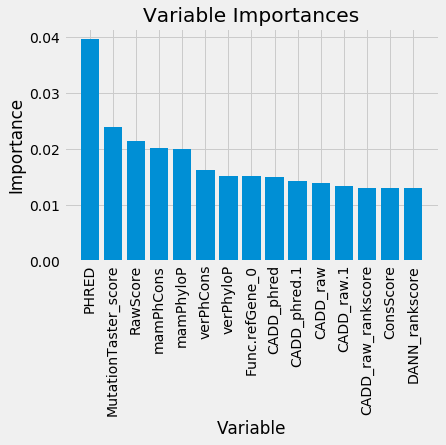

In [262]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(feature_importances_values[:15])))
# Make a bar chart
plt.bar(x_values, feature_importances_values[:15], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_importances_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we plot the first 300 feature importances. The graph below shows how influential each figure is to the model. As we will see, there are only a few features that impact the model followed by a steep dropoff of the remaining features. For the future, it is possible to only keep the features who show a high importance value and drop the rest. Below we show how many features, out of the 44,045 total features, had a large impact on the classification of variants:

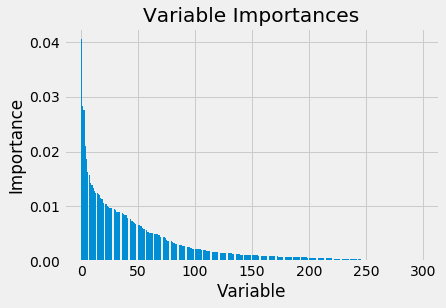

In [186]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values[:300])))
plt.bar(x_values, feature_importances_values[:300], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

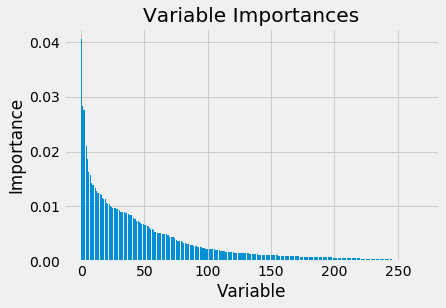

In [188]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values[:270])))
plt.bar(x_values, feature_importances_values[:270], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we see the final graph of importances. This means that if we take only the first 250 features for our model above in the list, our model will show very similar outputs. We will test this further on:

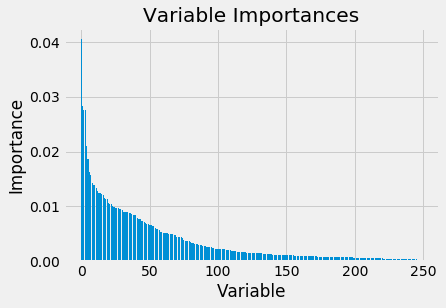

In [189]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values[:250])))
plt.bar(x_values, feature_importances_values[:250], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we create a picture of the fifth decision tree. This can be found in our home directory once this code is run with the name 'tree.png':

In [ ]:
#First need to run pip install pydot and sudo-apt get install graphviz
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rforest.estimators_[:5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

Below we have shown the first 250 annotations to be used in a new model to see if we get the same result as before:

In [ ]:
feature_importances_list[:250]

### Now we only keep the columns above. In order to create this dataframe, we must recall the orignal features function when it was made by concatenating the benign and pathogenic variants, dropping columns unnecessary for the model, and one hot encoding the data. Only then can we call the next cell (remember to keep the category column in the dataframe):

In [197]:
features_less_columns = features[['PHRED', 'RawScore', 'mamPhCons', 'tOverlapMotifs', 'GerpRS', 'integrated_fitCons_score_rankscore', 'verPhCons', 'FeatureID_ENST00000650585', 'CADD_phred', 'CADD_phred.1', 'CADD_raw', 'CADD_raw.1', 'CADD_raw_rankscore', 'ConsScore', 'DANN_rankscore', 'DANN_score', 'Eigen-raw', 'EncodetotalRNA-max', 'EncodetotalRNA-sum', 'GERP++_RS', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'MutationTaster_score', 'MutationTaster_score.1', 'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds.1', 'category', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'fathmm-MKL_coding_score', 'motifEScoreChng', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian_rankscore', 'phyloP100way_vertebrate', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian_rankscore', 'phyloP46way_placental', 'ConsDetail_inframe_insertion', 'Consequence_INFRAME', 'Domain_sigp', 'Dst2SplType_DONOR', 'Func.ensGene_intergenic', 'Func.ensGene_upstream;downstream', 'Func.knownGene_intergenic', 'Func.knownGene_upstream;downstream', 'Func.refGene_intergenic', 'Func.refGene_ncRNA_splicing', 'Func.refGene_upstream;downstream', 'Gene.ensGene_snoU13;AC034243.1', 'Gene.knownGene_ZYX', 'MutationAssessor_pred.1_N', 'MutationTaster_pred_A', 'MutationTaster_pred_N', 'MutationTaster_pred.1_A', 'cosmic70_ID=COSM957996;OCCURENCE=1(endometrium)', 'fathmm-MKL_coding_pred_0', 'regsnp_disease_B', 'regsnp_splicing_site_off', 'CDSpos', 'CpG', 'Dist2Mutation', 'Dst2Splice', 'Eigen-PC-raw', 'EncodeDNase-max', 'EncodeDNase-sum', 'EncodeH2AFZ-max', 'EncodeH2AFZ-sum', 'EncodeH3K27ac-max', 'EncodeH3K27ac-sum', 'EncodeH3K27me3-max', 'EncodeH3K27me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me1-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me3-max', 'EncodeH3K4me3-sum', 'EncodeH3K79me2-max', 'EncodeH3K79me2-sum', 'EncodeH3K9ac-max', 'EncodeH3K9ac-sum', 'EncodeH3K9me3-max', 'EncodeH3K9me3-sum', 'EncodeH4K20me1-max', 'EncodeH4K20me1-sum', 'FATHMM_converted_rankscore', 'FATHMM_score', 'FATHMM_score.1', 'Freq10000bp', 'Freq1000bp', 'Freq100bp', 'GC', 'GerpRSpval', 'Grantham', 'LRT_converted_rankscore', 'LRT_score', 'LRT_score.1', 'LR_score', 'M-CAP_rankscore', 'M-CAP_score', 'MCAP', 'MetaLR_rankscore', 'MetaLR_score', 'MetaSVM_rankscore', 'MetaSVM_score', 'MutationAssessor_score', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'MutationTaster_converted_rankscore', 'PROVEAN_converted_rankscore', 'PROVEAN_score', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HDIV_score', 'Polyphen2_HDIV_score.1', 'Polyphen2_HVAR_rankscore', 'Polyphen2_HVAR_score', 'Polyphen2_HVAR_score.1', 'REVEL', 'RadialSVM_score', 'Rare10000bp', 'Rare1000bp', 'Rare100bp', 'RemapOverlapCL', 'RemapOverlapTF', 'SIFT_converted_rankscore', 'SIFT_score', 'SIFT_score.1', 'SIFTval', 'SiPhy_29way_logOdds_rankscore', 'Sngl10000bp', 'Sngl1000bp', 'Sngl100bp', 'VEST3_rankscore', 'VEST3_score', 'VEST3_score.1', 'bStatistic', 'cDNApos', 'fathmm-MKL_coding_rankscore', 'integrated_fitCons_score', 'mamPhyloP', 'minDistTSE', 'minDistTSS', 'mirSVR-Aln', 'mirSVR-E', 'mirSVR-Score', 'motifDist', 'motifECount', 'motifEHIPos', 'phastCons20way_mammalian', 'phyloP20way_mammalian', 'priPhyloP', 'protPos', 'regsnp_fpr', 'relCDSpos', 'relProtPos', 'relcDNApos', 'verPhyloP', 'Alt_A', 'Alt_AA', 'Alt_AAA', 'Alt_AAAGATGTCC', 'Alt_AAAGT', 'Alt_AAG', 'Alt_AAGG', 'Alt_AAGTT', 'Alt_AC', 'Alt_ACATG', 'Alt_ACC', 'Alt_AG', 'Alt_AGA', 'Alt_AGAATTCT', 'Alt_AGAGT', 'Alt_AGCCGGCCC', 'Alt_AGCGCGGCAGGGT', 'Alt_AGCGGT', 'Alt_AGG', 'Alt_AGGGTGCT', 'Alt_AGGGTGCTCCTGGTGCTGT', 'Alt_AGGT', 'Alt_AGGTT', 'Alt_AGT', 'Alt_AGTCT', 'Alt_AGTTAC', 'Alt_AT', 'Alt_ATC', 'Alt_ATGATG', 'Alt_ATTCATGTTATCTACAGAC', 'Alt_ATTTTCCTGACAG', 'Alt_C', 'Alt_CA', 'Alt_CAA', 'Alt_CACGAG', 'Alt_CACGG', 'Alt_CAG', 'Alt_CAGTT', 'Alt_CATAGTTACCGTACACGAGAAG', 'Alt_CATGT', 'Alt_CCAAAA', 'Alt_CCACT', 'Alt_CCAGT', 'Alt_CCGGCCGGCC', 'Alt_CG', 'Alt_CGG', 'Alt_CGGGCT', 'Alt_CT', 'Alt_CTATGGAGTGTG', 'Alt_CTATGT', 'Alt_CTCAA', 'Alt_CTTTCT', 'Alt_G', 'Alt_GA', 'Alt_GAA', 'Alt_GAGGC', 'Alt_GAT', 'Alt_GATACGCA', 'Alt_GATACTTTTTCTCATCA', 'Alt_GATGTGAA', 'Alt_GATTA', 'Alt_GATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCTATTCT', 'Alt_GC', 'Alt_GCA', 'Alt_GCAGCAGCATGAGCCCACT', 'Alt_GCAGGCGGAGCACCCCAAGC', 'Alt_GCCCAAA', 'Alt_GCGGCGGCGGC', 'Alt_GCT', 'Alt_GCTGA', 'Alt_GCTTCCAGGGA', 'Alt_GCTTTT', 'Alt_GGAAT', 'Alt_GGC', 'Alt_GGCGAGCACGACCTCA', 'Alt_GGGAC', 'Alt_GGGC', 'Alt_GGGCGGCGGCGGCAACTCCACCGC', 'Alt_GGGTC', 'Alt_GGGTGCTCCTGGTGCTGTA', 'Alt_GGT', 'Alt_GT', 'Alt_GTAAA', 'Alt_GTACTC', 'Alt_GTC']]
features_less_columns
# Notice how we only have 230 columns now

PHRED  RawScore  mamPhCons  tOverlapMotifs  ...  Alt_GT  Alt_GTAAA  \
0      12.600  1.043084      0.000             0.0  ...     0.0        0.0   
1      12.600  1.043084      0.000             0.0  ...     0.0        0.0   
2       0.135 -0.385227      0.002             0.0  ...     0.0        0.0   
3       0.135 -0.385227      0.002             0.0  ...     0.0        0.0   
...       ...       ...        ...             ...  ...     ...        ...   
26643   1.615 -0.015496      0.000             0.0  ...     0.0        0.0   
26644   3.639  0.167494      0.004             0.0  ...     0.0        0.0   
26645   3.516  0.158022      0.049             0.0  ...     0.0        0.0   
26646   1.024 -0.096828      0.000             0.0  ...     0.0        0.0   

       Alt_GTACTC  Alt_GTC  
0             0.0      0.0  
1             0.0      0.0  
2             0.0      0.0  
3             0.0      0.0  
...           ...      ...  
26643         0.0      0.0  
26644         0.0      0.0  
26645         0.0      0.0  
26646         0.0      0.0  

[26647 rows x 250 columns]

Now we repeat the analysis as we had done before in order to create a new model:

In [198]:
labels_less_columns = features_less_columns['category']
labels_less_columns

0        1
1        1
2        1
3        1
        ..
26643    0
26644    0
26645    0
26646    0
Name: category, Length: 26647, dtype: int64

Below we made our category column into a numpy array to be used in the model:

In [199]:
labels_less_columns = labels_less_columns.to_numpy()
labels_less_columns

array([1, 1, 1, ..., 0, 0, 0])

Below we drop the category column because our machine learning model uses it only for the labels:

In [200]:
features_less_columns = features_less_columns.drop('category', axis = 1)
features_less_columns.head()

PHRED  RawScore  mamPhCons  tOverlapMotifs  ...  Alt_GT  Alt_GTAAA  \
0  12.600  1.043084      0.000             0.0  ...     0.0        0.0   
1  12.600  1.043084      0.000             0.0  ...     0.0        0.0   
2   0.135 -0.385227      0.002             0.0  ...     0.0        0.0   
3   0.135 -0.385227      0.002             0.0  ...     0.0        0.0   
4  27.800  4.406680      0.995             0.0  ...     0.0        0.0   

   Alt_GTACTC  Alt_GTC  
0         0.0      0.0  
1         0.0      0.0  
2         0.0      0.0  
3         0.0      0.0  
4         0.0      0.0  

[5 rows x 249 columns]

Below we create a list of the column names which we will use later to see the influence of each annotation:

In [201]:
feature_list_less_columns = list(features_less_columns.columns)

Below we show the number of columns in the dataframe:

In [202]:
len(features_less_columns.columns)

249

Now that all our data is numeric, we want to transform it into a numpy array to use in our model:

In [203]:
features_less_columns = features_less_columns.to_numpy()

Now we will split our data into testing and training data to later use for our model. We do a 75% training data to 25% testing data split:

In [204]:
train_features_less_columns, test_features_less_columns, train_labels_less_columns, test_labels_less_columns = train_test_split(features_less_columns, labels_less_columns, test_size = 0.25, random_state = 100)

Below we show the dataframe for the training set:

In [205]:
pd.options.display.max_rows = 8
pd.options.display.max_columns = 10
train_features_less_columns

array([[ 1.257000e+00, -6.128500e-02,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 3.790000e-01, -2.507170e-01,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 2.270000e+01,  2.782963e+00,  4.800000e-02, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       ...,
       [ 2.037000e+00,  3.040000e-02,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 5.334000e+00,  3.029940e-01,  9.000000e-03, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 3.200000e+01,  4.747150e+00,  1.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])

Below we show the dataframe for the testing set:

In [206]:
test_features_less_columns

array([[2.223000e+00, 4.878200e-02, 8.300000e-02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.614000e+01, 1.574346e+00, 9.710000e-01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [4.426000e+00, 2.282640e-01, 1.000000e-03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.490000e+01, 3.763800e+00, 9.860000e-01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.869000e+00, 1.285600e-02, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.970000e+01, 4.630732e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

Below we show the list of training labels from our category column:

In [207]:
train_labels_less_columns

array([0, 0, 1, ..., 0, 0, 1])

Below we show the list of testing labels from our category column:

In [208]:
test_labels_less_columns

array([0, 1, 0, ..., 1, 0, 1])

To see the dimensions of the arrays we are using for our model, we execute the following code:

In [209]:
print('Training Features Shape:', train_features_less_columns.shape)
print('Training Labels Shape:', train_labels_less_columns.shape)
print('Testing Features Shape:', test_features_less_columns.shape)
print('Testing Labels Shape:', test_labels_less_columns.shape)

Training Features Shape: (19985, 249)
Training Labels Shape: (19985,)
Testing Features Shape: (6662, 249)
Testing Labels Shape: (6662,)


Below we run our model with all data keeping in mind all the parameters for the RandomForestClassifier function:

In [210]:
from sklearn.ensemble import RandomForestClassifier
rforest_less_columns = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf = 5, bootstrap = False)
model_less_columns = rforest_less_columns.fit(train_features_less_columns, train_labels_less_columns)
#RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_split=1e-07, min_samples_leaf=5,
#            min_samples_split=5, min_weight_fraction_leaf=0.0,
#            n_estimators=500, n_jobs=2, oob_score=False, random_state=0,
#            verbose=0, warm_start=False)

Below we run cross validation on our model to see how well it performed on the training data:

In [211]:
# Perform 6-fold cross validation
scores_less_columns = cross_val_score(model_less_columns, train_features_less_columns, train_labels_less_columns, cv=6, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores_less_columns)

Cross-validated scores: [0.9882918  0.98378865 0.98498949 0.98408886 0.98709096 0.98888889]


Now we create a precision-recall curve for the classifier following the guidelines of https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/:

f1=0.986 auc=0.999 ap=0.999


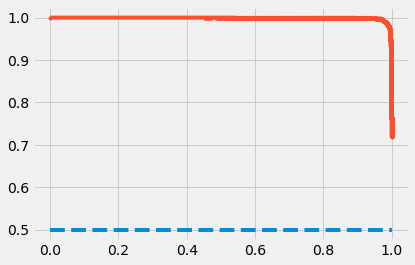

In [212]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
probs_less_columns = model_less_columns.predict_proba(test_features_less_columns)
probs_less_columns = probs_less_columns[:,1]
labels_hat_less_columns = model_less_columns.predict(test_features_less_columns)
precision, recall, thresholds = precision_recall_curve(test_labels_less_columns, probs_less_columns)
f1_less_columns = f1_score(test_labels_less_columns, labels_hat_less_columns)
auc_less_columns = auc(recall, precision)
ap_less_columns = average_precision_score(test_labels_less_columns, probs_less_columns)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_less_columns, auc_less_columns, ap_less_columns))
plt.plot([0,1], [0.5, 0.5], linestyle = '--')
plt.plot(recall, precision, marker = '.')
plt.show()

Below we show how much each annotation actually influenced the classification of the variants for this model:

In [ ]:
# Get numerical feature importances
importances_less_columns = list(rforest_less_columns.feature_importances_)
# List of tuples with variable and importance
feature_importances_less_columns = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_less_columns, importances_less_columns)]
# Sort the feature importances by most important first
feature_importances_less_columns = sorted(feature_importances_less_columns, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_less_columns];

Below we make a list of the annotation names corresponding to the importances in descending order:

In [ ]:
feature_importances_list_less_columns = [x for x,_ in feature_importances_less_columns]
feature_importances_list_less_columns

Below we make a list of the importances of the annotations in descending order. NOTICE HOW IN THIS DEFINITION OF feature_importances, WE DID NOT ROUND THE IMPORTANCE AS WE DID ABOVE:

In [ ]:
feature_importances_less_columns = [(feature, importance) for feature, importance in zip(feature_list_less_columns, importances_less_columns)]
feature_importances_less_columns = sorted(feature_importances_less_columns, key = lambda x: x[1], reverse = True)
feature_importances_values_less_columns = [y for _,y in feature_importances_less_columns]
feature_importances_values_less_columns

Below we plot a graph of the first 15 features from the list above:

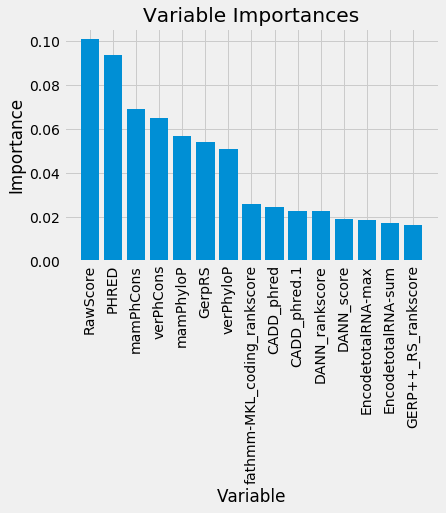

In [216]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(feature_importances_values_less_columns[:15])))
# Make a bar chart
plt.bar(x_values, feature_importances_values_less_columns[:15], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_importances_list_less_columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we plot the 250 feature importances. The graph below shows how influential each figure is to the model. As we will see, there are only a few features that impact the model followed by a steep dropoff of the remaining features. For the future, it is possible to only keep the features who show a high importance value and drop the rest. Below we show how many features, out of the 250 total features, had a large impact on the classification of variants:

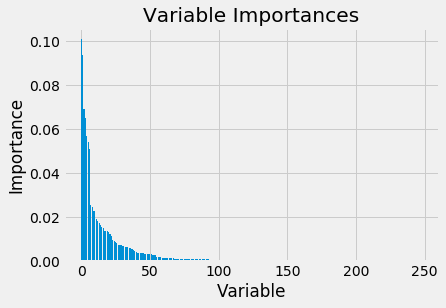

In [220]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values_less_columns[:250])))
plt.bar(x_values, feature_importances_values_less_columns[:250], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

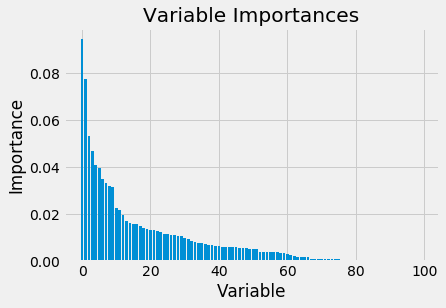

In [198]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values_less_columns[:100])))
plt.bar(x_values, feature_importances_values_less_columns[:100], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we see the final graph of importances. This means that if we take only the first 75 features for our model above in the list, our model will show very similar outputs. We will test this further on:

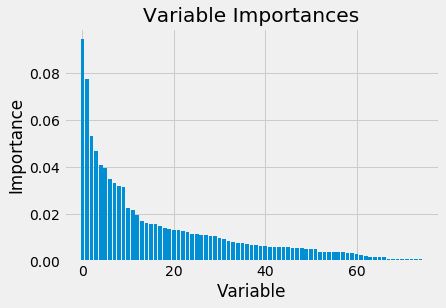

In [206]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values_less_columns[:75])))
plt.bar(x_values, feature_importances_values_less_columns[:75], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we create a model with less trees in order to visualize the spread of the data better:

In [248]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=10, min_samples_split=5, min_samples_leaf = 5, bootstrap = False)
model = rforest.fit(train_features, train_labels)
#RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_split=1e-07, min_samples_leaf=5,
#            min_samples_split=5, min_weight_fraction_leaf=0.0,
#            n_estimators=500, n_jobs=2, oob_score=False, random_state=0,
#            verbose=0, warm_start=False)

Below we run cross validation on our model to see how well it performed on the training data:

In [249]:
# Perform 6-fold cross validation
scores = cross_val_score(model, train_features, train_labels, cv=6, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.9852897  0.98348844 0.98438907 0.98078655 0.9852897  0.98558559]


Now we create a precision-recall curve for the classifier following the guidelines of https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/:

f1=0.976 auc=0.996 ap=0.996


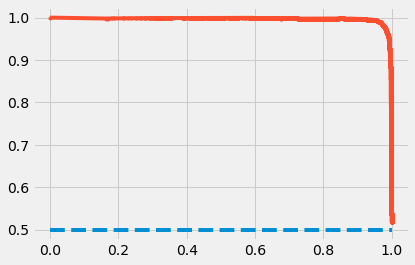

In [250]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
probs = model.predict_proba(test_features)
probs = probs[:,1]
labels_hat = model.predict(test_features)
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
f1 = f1_score(test_labels, labels_hat)
auc = auc(recall, precision)
ap = average_precision_score(test_labels, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
plt.plot([0,1], [0.5, 0.5], linestyle = '--')
plt.plot(recall, precision, marker = '.')
plt.show()

Below we visualize the fifth tree of the 10 decision trees of the model above:

In [253]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rforest.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rforest.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree_small.png')